## imgAna_OpenCV * snap for home....



In [1]:
!pip install opencv-contrib-python

In [36]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from statistics import mean
from collections import deque
from collections import Counter

import json
import datetime 

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout

from bs4 import BeautifulSoup

%matplotlib inline

from sseclient import SSEClient as EventSource

from ipywidgets import Button, HBox, VBox, Layout

from  functools import lru_cache
import requests

from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context

import time
from PIL import Image,  ImageDraw  # https://pillow.readthedocs.io/en/4.3.x/
import io
import base64


In [2]:
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    """
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

from icpd_core import icpd_util
cfg=icpd_util.get_service_instance_details(name='zen-sample-icp1-blitz-env')
def get_instance():
    """Setup to access your Streams instance.

    ..note::The notebook is work within Cloud and ICP4D. 
            Refer to the 'Setup' cells above.              
    Returns:
        instance : Access to Streams instance, used for submitting and rendering views.
    """
    try:
        from icpd_core import icpd_util
        import urllib3
        global cfg
        cfg[context.ConfigParams.SSL_VERIFY] = False
        instance = rest.Instance.of_service(cfg)
        print("Within ICP4D")
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    except ImportError:
        cfg = None
        print("Outside ICP4D")
        import credential  
        sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', 
                                               vcap_services=credential.vcap_conf)
        instance = sc.get_instances()[0]
    return instance,cfg

instance,cfg = get_instance()

Within ICP4D


/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


## Process a local file

<class 'numpy.ndarray'>
(240, 362, 3)


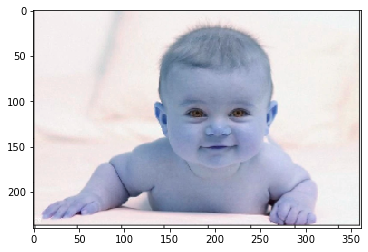

In [3]:
#img_raw = cv2.imread('../facialLocation.jpg')
img_raw = cv2.imread('../datasets/baby1.png')
print(type(img_raw))
print(img_raw.shape)
plt.imshow(img_raw)

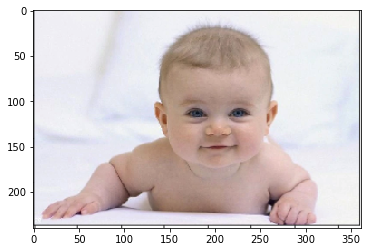

In [4]:
img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

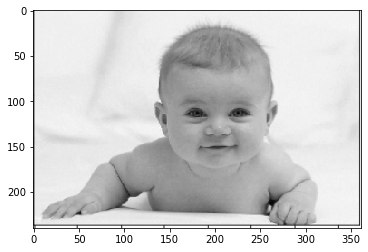

In [5]:
#Converting to grayscale
img_bw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

# Displaying the grayscale image
plt.imshow(img_bw, cmap='gray')

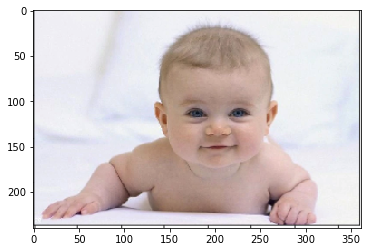

In [6]:
def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(convertToRGB(img_raw))

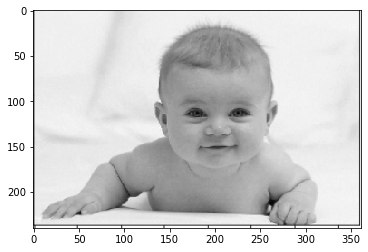

In [7]:
def convertToBW(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(convertToBW(img_raw), cmap='gray')

In [8]:
haar_cascade_face = cv2.CascadeClassifier('../datasets/haarcascade_frontalface_default.xml')
haar_cascade_face

<CascadeClassifier 0x7f59f1b29e70>

In [9]:
faces_rects = haar_cascade_face.detectMultiScale(img_bw, scaleFactor = 1.2, minNeighbors = 5);

# Let us print the no. of faces found
print("Faces found: {} faces within regions:{}".format(len(faces_rects), faces_rects))


Faces found: 1 faces within regions:[[138  56 140 140]]


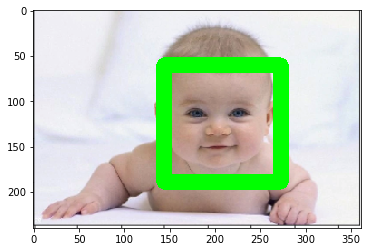

In [10]:
def detect_faces(image, cascade, scaleFactor = 1.1):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = image.copy()

    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = convertToBW(image_copy)

    # Applying the haar classifier to detect faces
    image_rects = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    return image_rects

def rects_render(image, rects):
    image_copy = image.copy()
    for (x, y, w, h) in rects:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 15)
    return image_copy
    
img_raw = cv2.imread('../datasets/baby1.png')
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
if len(rects)> 0:
    img_rects = rects_render(img_rgb, rects)
    plt.imshow(img_rects)
else:
    print("On image")

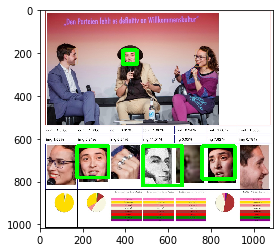

In [11]:
img_raw = cv2.imread('../datasets/imgClassify.jpg')
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
img_rects = rects_render(img_rgb, rects)
plt.imshow(img_rects)

## Fetch a file from the web
Problem - 

The image that gets processed is not the same image that is sent which makes the face region wrong. 
Notes:
- do not want to send images from streams
- Streams get the image, render gets image
- region overlays on image that is fetched.
- get the face detection to work on the exact original image
- work out the proportion between the computed image region and the original


Use the the URLs for testing.

In [81]:
urls = ["https://upload.wikimedia.org/wikipedia/commons/1/1e/Christopher_de_Paus.JPG",
       "https://upload.wikimedia.org/wikipedia/commons/a/a5/Anne_Bethel_Spencer_in_her_wedding_dress.jpg",
       "https://upload.wikimedia.org/wikipedia/commons/f/f7/Barbara_Anderson_1969.JPG"]


In [76]:
def bts_to_img(bts):
    '''
    :param bts: results from image_to_bts
    '''
    buff = np.fromstring(bts, np.uint8)
    buff = buff.reshape(1, -1)
    img = cv2.imdecode(buff, cv2.IMREAD_COLOR)
    return img

IMAGE = None
global IMAGE
def render_image(image_url=None, output_region=None, rect_region=None):
    global IMAGE
    """Write the image into a output region.
    
    Args::
        url: image
        output_region: output region
        
    .. note:: The creation of the output 'stage', if this is not done the image is rendered in the page and
        the output region. 
        
    """
    
    try:
        response = requests.get(image_url)
        stage = widgets.Output(layout={'border': '1px solid green'})
    except:
        print("Error on request : ", image_url)
    else:
        if response.status_code == 200:
            with output_region:
                IMAGE = response.content
                stage.append_display_data(widgets.Image(
                    value=response.content,
                    #format='jpg',
                    width=300,
                    height=400,
                ))
            output_region.clear_output(wait=True)
            img_raw = bts_to_img(IMAGE)
            img_rgb = convertToRGB(img_raw)
            rects = detect_faces(img_rgb, haar_cascade_face)
            print("len:", len(rects))
            """
            if len(rects) is not 0:
                with Image.open(io.BytesIO(IMAGE)) as bin_image:
                    face_crops = face_crop(IMAGE,rects[0])
                    crop_image = encode_img(face_crops['annotated_image'])
                    with rect_region:
                        fullImg = face_crops['annotated_image']
                        dspImg = resize_image(fullImg, baseheight=400)
                        display(dspImg)
                        clear_output(wait=True)
            """

            

ana_stage = list()
def display_image(tup, image_region=None, rect_region=None, title_region=None, url_region=None):
    if tup['img_desc'] is not None and len(tup['img_desc']) > 0:
        display_desc = tup['img_desc'][0]
        ana_stage.append(display_desc)
        title_region.value = "Img Title:{}".format(display_desc['title'] )
        url_region.value = "{}".format(display_desc['img'])
        render_image(image_url=display_desc['img'], output_region=image_region, rect_region=rect_region)





In [77]:

## Setup the Dashboard - display images sent to Wikipedia 
##                         Next cell populates the 'Dashboard'.....
status_widget = widgets.Label(value="Status", layout={'border': '1px solid green','width':'30%'})
url_widget = widgets.Label(value="Img URL", layout={'border': '1px solid green','width':'100%'})
image_widget = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'200pt'})
rect_widget = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'200pt'})
title_widget = widgets.Label(value="Title", layout={'border': '1px solid green','width':'30%'})
dashboard = widgets.VBox([status_widget, image_widget, rect_widget, title_widget, url_widget])
display(dashboard)

In [82]:
# Notebook support
# setup 
_view = instance.get_views(name="soupActive")[0]
_view.start_data_fetch()

@catchInterrupt
def server_soup(count=25):
    """Fetch and display images from view.
    Args::
        count: number of iterations to fetch images, count<0
        is infinite
    """
    while count != 0:
        count -= 1
        view_tuples = _view.fetch_tuples(max_tuples=100, timeout=2)
        for soup_tuple in view_tuples:
            status_widget.value = soup_tuple['title']
            display_image(soup_tuple, image_region=image_widget, rect_region=rect_widget, title_region=title_widget, url_region=url_widget)

server_soup()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


len: 19
len: 1
len: 0
len: 0
len: 6
len: 9
len: 4
len: 9
len: 4
len: 4
len: 5
len: 4
len: 50
len: 0
len: 0
len: 0
len: 1
len: 26
len: 14
len: 1
len: 1


In [22]:
rects = detect_faces(img_rgb, haar_cascade_face)


img_raw = bts_to_img(IMAGE)
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
print("len:", len(rects))
if len(rects) is not 0:
    img_rects = rects_render(img_rgb, rects)


stage = widgets.Output(layout={'border': '1px solid green'})
with rect_widget:
                stage.append_display_data(widgets.Image(
                    value=img_rgb,
                    #format='jpg',
                    width=300,
                    height=400,
                ))

len: 1


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [24]:
type(img_rgb)

numpy.ndarray

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


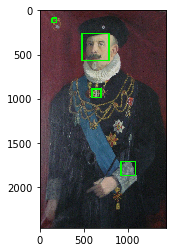

In [70]:
img_raw = bts_to_img(IMAGE)
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
img_rects = rects_render(img_rgb, rects)
plt.imshow(img_rects)

In [22]:
with rect_widget:
    stage.append_display_data(widgets.Image(value=img_rects, width=300, height=400))


In [25]:
type(img_rects)

numpy.ndarray

In [28]:
type(IMAGE)
%matplotlib inline 

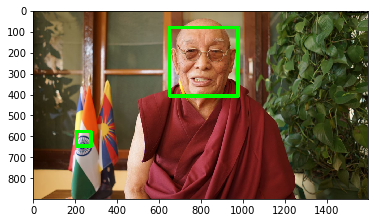

In [69]:
from matplotlib import pyplot as plt
plt.imshow(img_rects, interpolation='nearest')
plt.show()

In [41]:
print(rects)
def line_box(ele):
    """build a box with lines."""
    return (ele[0],ele[1],ele[0],ele[3],ele[2],ele[3],ele[2],ele[1],ele[0],ele[1])

def decode_img(bin64):
    """must be easier way"""
    img = Image.open(io.BytesIO(base64.b64decode(bin64)))
    return img


[[282 201 487 487]]


<function __main__.detect_faces(image, cascade, scaleFactor=1.1)>

In [59]:
r_widget = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'200pt'})

dashboard = widgets.VBox([r_widget])
display(dashboard)

In [68]:
def face_crop(bin_image, detection_box):
    """Crop out the faces from a URL using detection_box and send to analysis.
    Args:
        url : image images
        faces : list of {region,predictions} that that should be cropped
    Return:
        dict with 'annotated_image' and 'crops'
        'crops' is list of dicts with 
            {image:face image, 
             probability:chances it's a face, 
             image_percent:found reqion % of of the image, 
             detection_box:region of the original image that the image was extacted from}
         'crops' empty - nothing found, no faces found
    """
    crops = list()
    draw = ImageDraw.Draw(bin_image) 
    box_width = 5 
    draw.line(line_box(detection_box), fill="red", width=box_width)
    #draw.rectangle(detection_box, fill=128)
    return {'annotated_image':bin_image}

def encode_img(img):
    """must be easier way"""
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        contents = output.getvalue() 
    return base64.b64encode(contents).decode('ascii')

def resize_image(bin_image, basewidth=None, baseheight=None):
    """Resize image proportional to the base, make it fit in cell"""
    if basewidth is not None:
        wpercent = (basewidth/float(bin_image.size[0]))
        hsize = int((float(bin_image.size[1])*float(wpercent)))
        return bin_image.resize((basewidth,hsize), Image.ANTIALIAS)
    wpercent = (baseheight/float(bin_image.size[1]))
    wsize = int((float(bin_image.size[0])*float(wpercent)))
    return bin_image.resize((wsize,baseheight), Image.ANTIALIAS)

def decode_img(bin64):
    """must be easier way"""
    img = Image.open(io.BytesIO(base64.b64decode(bin64)))
    return img

with Image.open(io.BytesIO(IMAGE)) as bin_image:
    bimg = bin_image
    #display(bimg)
    face_crops = face_crop(bimg,rects[1])
    crop_image = encode_img(face_crops['annotated_image'])
    with r_widget:
        fullImg = face_crops['annotated_image']
        dspImg = resize_image(fullImg, baseheight=400)
        display(dspImg)
        clear_output(wait=True)
